In [116]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [117]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [118]:
len(words)

32033

In [119]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [120]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [121]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd*block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.02
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # no of paramters in total
for p in parameters:
    p.requires_grad = True 

12297


In [122]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X, Y

    # forward pass
    emb = C[Xb]                             #                              [32, 3, 10]
    embcat = emb.view(emb.shape[0], -1)     # concatenate the vectors      [32,  30]
    hpreact = embcat @ W1 + b1              # hidden layer pre-activation; [32, 200]
    hpreact = bngain * ((hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)) + bnbias
    h = torch.tanh(hpreact)                 # hidden layer                 [32, 200]  
    logits = h @ W2 + b2                    # output layer                 [32,  27]
    loss = F.cross_entropy(logits, Yb)      # loss function                

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


In [125]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  # hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0668270587921143
val 2.104844808578491


In [63]:
h

tensor([[ 0.8100, -0.8997, -0.9993,  ..., -0.9097, -1.0000,  1.0000],
        [-1.0000, -0.9571, -0.7145,  ...,  0.4898,  0.9090,  0.9937],
        [ 0.9983, -0.3340,  1.0000,  ...,  0.9443,  0.9905,  1.0000],
        ...,
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        [-1.0000, -0.4385, -0.8882,  ..., -0.3316,  0.9995,  1.0000],
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000]],
       grad_fn=<TanhBackward0>)

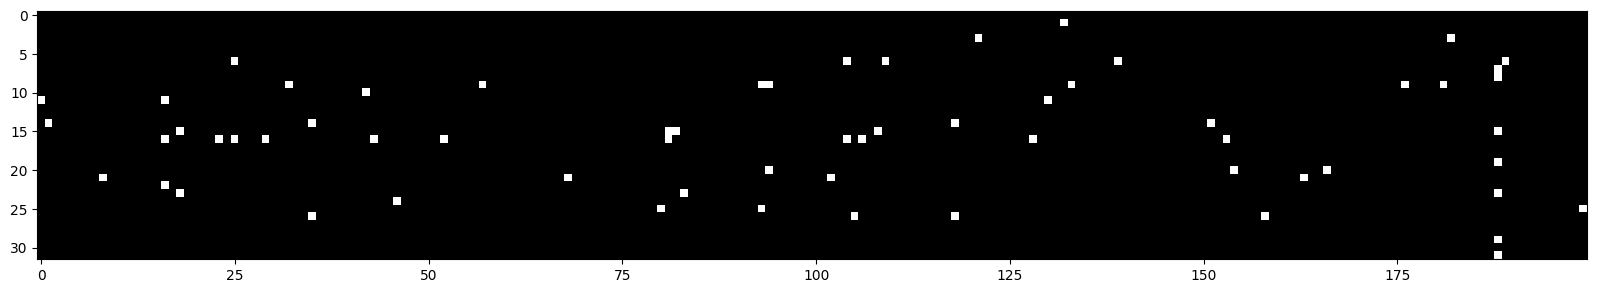

In [79]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

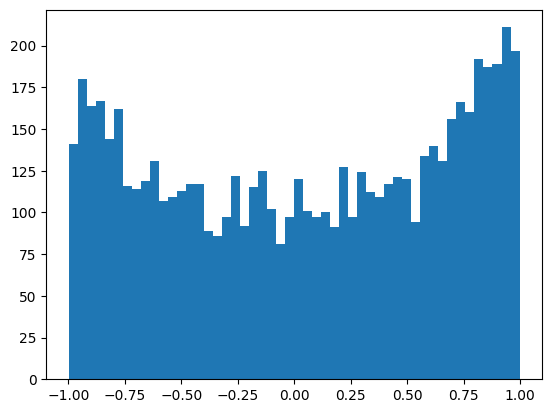

In [80]:
plt.hist(h.view(-1).tolist(), 50);

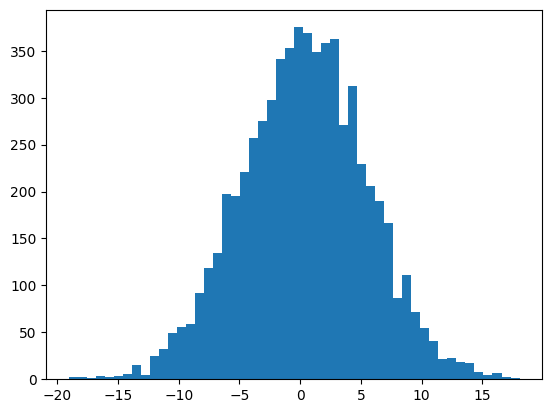

In [76]:
plt.hist(hpreact.view(-1).tolist(), 50);

In [73]:
logits[0]

tensor([-0.0249,  0.3523, -0.1267,  0.0541,  0.1662, -0.1171, -0.0140,  0.0124,
         0.0921,  0.1135,  0.1362, -0.0925,  0.0444, -0.2459, -0.0971,  0.0125,
        -0.0957, -0.1376, -0.2329, -0.0137,  0.2452,  0.1616,  0.1665, -0.1094,
        -0.2154,  0.0725,  0.1141], grad_fn=<SelectBackward0>)

In [74]:
# 4-dimensional example of the issue
# logits = torch.tensor([-3.0, 5.0, 0.0, 0.0])
logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([1.9438e-04, 9.9972e-01, 8.8056e-05, 4.7760e-08]), tensor(9.3375))

In [24]:
-torch.tensor(1/27).log()  # loss if each outcome is as likely as others

tensor(3.2958)

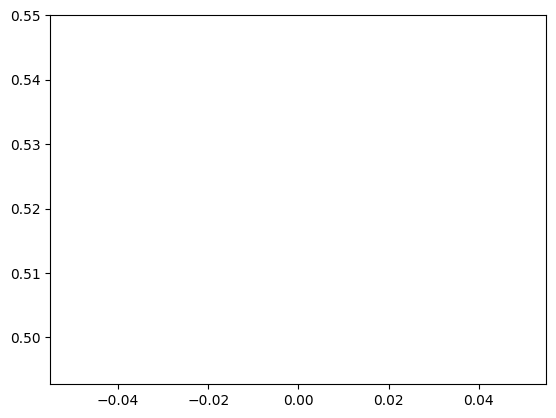

In [72]:
plt.plot(lossi)